<a href="https://colab.research.google.com/github/arthurvaz05/Python.Script/blob/master/Grafo_RSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install networkx

# Carregar as bibliotecas

In [56]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Carregar as bases

In [2]:
#Extrair os dataset através desse site -> https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/All_Beauty.json.gz

--2023-05-15 12:04:07--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/All_Beauty.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47350910 (45M) [application/x-gzip]
Saving to: ‘All_Beauty.json.gz.2’

All_Beauty.json.gz. 100%[===================>]  45.16M  14.4MB/s    in 3.1s    

2023-05-15 12:04:11 (14.4 MB/s) - ‘All_Beauty.json.gz.2’ saved [47350910/47350910]



In [3]:
#Habilitar o acesso ao meu drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Verificar onde o metadado se encontra no meu drive
#!ls /content/drive/MyDrive/meta_All_Beauty.json.gz

In [5]:
### carregar os dados

data_meta = []
with gzip.open('/content/drive/MyDrive/meta_All_Beauty.json.gz') as f:
    for l in f:
        data_meta.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data_meta))

# first row of the list
print(data_meta[0])

32892
{'category': [], 'tech1': '', 'description': ["Loud 'N Clear Personal Sound Amplifier allows you to turn up the volume on what people around you are saying, listen at the level you want without disturbing others, hear a pin drop from across the room."], 'fit': '', 'title': "Loud 'N Clear&trade; Personal Sound Amplifier", 'also_buy': [], 'tech2': '', 'brand': 'idea village', 'feature': [], 'rank': '2,938,573 in Beauty & Personal Care (', 'also_view': [], 'details': {'ASIN: ': '6546546450'}, 'main_cat': 'All Beauty', 'similar_item': '', 'date': '', 'price': '', 'asin': '6546546450', 'imageURL': [], 'imageURLHighRes': []}


In [6]:
### carregar os dados

data = []
with gzip.open('All_Beauty.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

371345
{'overall': 1.0, 'verified': True, 'reviewTime': '02 19, 2015', 'reviewerID': 'A1V6B6TNIC10QE', 'asin': '0143026860', 'reviewerName': 'theodore j bigham', 'reviewText': 'great', 'summary': 'One Star', 'unixReviewTime': 1424304000}


In [7]:
# convert list into pandas dataframe

df = pd.DataFrame.from_dict(data)
df_meta = pd.DataFrame.from_dict(data_meta)

print(len(df))
print(len(df_meta))

371345
32892


# Tratamento das bases

In [8]:
df.loc[:,'key'] = df.reviewerID + ' ' + df.asin
df = df.loc[:,['overall','reviewerID','asin','key']]
df.drop_duplicates(inplace = True)

In [9]:
df = df.fillna('')
df_meta = df_meta.fillna('')

In [10]:
#df.head(5)

In [11]:
#df_meta.head(5)

In [12]:
#df.dtypes

In [13]:
#df_meta.dtypes

In [14]:
df.loc[:,'likes'] = df.overall.map( lambda x: 1 if x >=4 else 0)

In [15]:
df.shape

(361818, 5)

In [16]:
#selecionar apenas os usuários que fizeram mais de duas avaliações
review = pd.DataFrame(df.reviewerID.value_counts())
df = df.loc[df.reviewerID.isin(review[review.reviewerID >= 4].index),:]

In [17]:
df.shape

(8802, 5)

In [18]:
df_sample = df.sample(n=(int(np.round(len(df)*0.005,0))))

In [19]:
df_sample.shape

(44, 5)

# Grafos

In [ ]:
#um outro jeito de criar as arestas
#H = nx.from_pandas_edgelist(df, 
#                            source='reviewerID', 
#                            target='asin', 
#                            create_using=nx.Graph, 
#                            edge_attr='likes')

In [ ]:
G = nx.DiGraph(directed=True)
#Adicionando todos os vértices
G.add_nodes_from(pd.concat([df_sample.asin, df_sample.reviewerID], axis=0))
#Adicionando todas as arestas
G.add_edges_from(np.array(df_sample[df_sample.likes.eq(1)][['reviewerID', 'asin']]))

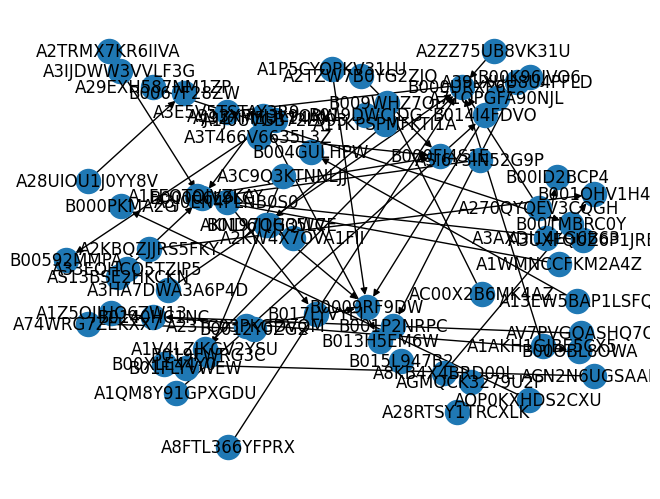

In [ ]:
pos = nx.random_layout(G)
nx.draw(G, pos, with_labels = True)

# Distâncias dos cossenos

In [20]:
#df_meta.loc[:,['asin','title']].head(5)

In [21]:
#df.head(5)

In [22]:
df = df.merge(df_meta.loc[:,['asin','title']], on='asin', how='left')
df = df.dropna()

In [23]:
df = df.drop_duplicates()

In [24]:
df = df.loc[:,['reviewerID','asin','likes','title']]

In [25]:
def create_list(x):
  return list(df.loc[df.reviewerID == x,'asin'])

In [26]:
listas = []
for i in range(len(list(df.reviewerID.drop_duplicates()))):
  j = list(df.reviewerID.drop_duplicates())[i]
  listas.append(create_list(j))

In [27]:
df2 = pd.DataFrame(df.reviewerID.drop_duplicates())

In [28]:
df2.loc[:,'Produtos_likes'] = listas

In [29]:
df2.Produtos_likes = df2.Produtos_likes.map( lambda x: ' '.join(x))

In [30]:
#df2 = pd.get_dummies(df.asin)
#df2.index = df.reviewerID
#df2


Scikit-learn's CountVectorizer is used to convert a collection of text documents to a vector of term/token counts. It also enables the ​pre-processing of text data prior to generating the vector representation. This functionality makes it a highly flexible feature representation module for text.

In [31]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df2.Produtos_likes)
#print("Count Matrix:", count_matrix.toarray())

In [32]:
cosine_sim = cosine_similarity(count_matrix)

In [33]:
df2.reset_index(inplace = True)

In [34]:
df2.drop(['index'], axis=1, inplace = True)

# Recomendação

In [35]:
#Usuário escolhido
df2.loc[1,:]

reviewerID                                     A141OPVE376YFI
Produtos_likes    B000050B65 B000050FDY B0002MQ9GK B000EG8HLE
Name: 1, dtype: object

In [36]:
#Escolha o usuário que receberá recomendação
similar_movies = list(enumerate(cosine_sim[1]))

In [37]:
sorted_similar_movies = sorted(similar_movies, key=lambda x:x[1], reverse=True)

In [38]:
sorted_similar_movies[0:4]

[(1, 1.0), (624, 0.5), (5, 0.25), (8, 0.25)]

In [39]:
z1 = pd.DataFrame(sorted_similar_movies[1:4])
z1.columns = ['index','semelhanca']
z1

,index,semelhanca
0,624,0.50
1,5,0.25
2,8,0.25


In [40]:
df2.loc[z1.loc[0,'index'],:]

reviewerID                                      AOP0KXHDS2CXU
Produtos_likes    B0002MQ9GK B0009MFUPY B000EG8HLE B000PKMA2G
Name: 624, dtype: object

In [41]:
df.loc[df.reviewerID==df2.loc[z1.loc[0,'index'],'reviewerID'],'title']

1301    Braun 8000 Activator Combi-Pack Foil and Cutte...
1333          Norelco Clean Jet Solution 10oz Cool Breeze
1730                     Philips Norelco BG2020 BodyGroom
7564    Philips Norelco 1050CC arcitec Men's Shaving S...
Name: title, dtype: object

In [42]:
# Produtos do cliente escolhido
produtos_escolhidos = df.loc[df.reviewerID==df2.loc[1,'reviewerID'],'title']
produtos_escolhidos = pd.DataFrame(produtos_escolhidos)

In [43]:
produtos_escolhidos = produtos_escolhidos.reset_index()
produtos_escolhidos = produtos_escolhidos.drop('index', axis = 1)

In [45]:
produtos = df.loc[df.reviewerID==df2.loc[z1.loc[0,'index'],'reviewerID'],'title']
produtos = pd.DataFrame(produtos)
produtos.loc[:,'cossenos'] = z1.loc[0,'semelhanca']
produtos.columns = ['from','semelhanca']
produtos.reset_index(inplace=True)
produtos.drop('index',inplace=True, axis = 1)
produtos = produtos[np.logical_not(produtos['from'].isin(produtos_escolhidos.title))]
produtos2 = produtos
produtos2.reset_index(inplace=True)

In [46]:
x = produtos2.loc[(0+1):len(produtos2)-1,'from']
x = pd.DataFrame(x)
x.column = 'from'
x.loc[:,'to'] = produtos2.loc[0,'from']
for i in range(1,(len(produtos2)-1)):
  #print(i)
  z = produtos2.loc[(i+1):len(produtos2)-1,'from']
  z = pd.DataFrame(z)
  z.column = 'from'
  z.loc[:,'to'] = produtos2.loc[i,'from']
  x = pd.concat([x,z], ignore_index=True)

In [47]:
x['peso'] = produtos['semelhanca'][0]

In [48]:
produtos = df.loc[df.reviewerID==df2.loc[z1.loc[1,'index'],'reviewerID'],'title']
produtos = pd.DataFrame(produtos)
produtos.loc[:,'cossenos'] = z1.loc[1,'semelhanca']
produtos.columns = ['from','semelhanca']
produtos.reset_index(inplace=True)
produtos.drop('index',inplace=True, axis = 1)
produtos = produtos[np.logical_not(produtos['from'].isin(produtos_escolhidos.title))]
produtos2 = produtos
produtos2.reset_index(inplace=True)

for i in range(1,(len(produtos2)-1)):
  #print(i)
  z = produtos2.loc[(i+1):len(produtos2)-1,'from']
  z = pd.DataFrame(z)
  z.column = 'from'
  z.loc[:,'to'] = produtos2.loc[i,'from']
  x = pd.concat([x,z], ignore_index=True)

In [49]:
x = x.fillna(produtos['semelhanca'][1])

In [50]:
x.loc[:,'semelhanca'] = 1

In [51]:
x

,from,to,peso,semelhanca
0,Philips Norelco 1050CC arcitec Men's Shaving S...,Norelco Clean Jet Solution 10oz Cool Breeze,0.50,1
1,Hesh Rose petal powder Herbal 100gms,Sol De Janeiro Brazilian Crush Body Fragrance ...,0.25,1


In [52]:
pd.concat([x['from'],x['to']]).drop_duplicates()

0    Philips Norelco 1050CC arcitec Men's Shaving S...
1                 Hesh Rose petal powder Herbal 100gms
0          Norelco Clean Jet Solution 10oz Cool Breeze
1    Sol De Janeiro Brazilian Crush Body Fragrance ...
dtype: object

https://www.harshaash.com/Python/Introduction%20to%20Networkx/

In [53]:
G = nx.Graph()
#Adicionando todos os vértices
G.add_nodes_from(pd.concat([x['from'], x['to']], axis=0))
#Adicionando todas as arestas
G.add_edges_from(np.array(x[x.semelhanca.eq(1)][['from', 'to']]), weights = np.array(x[x.semelhanca.eq(1)][['peso']]))

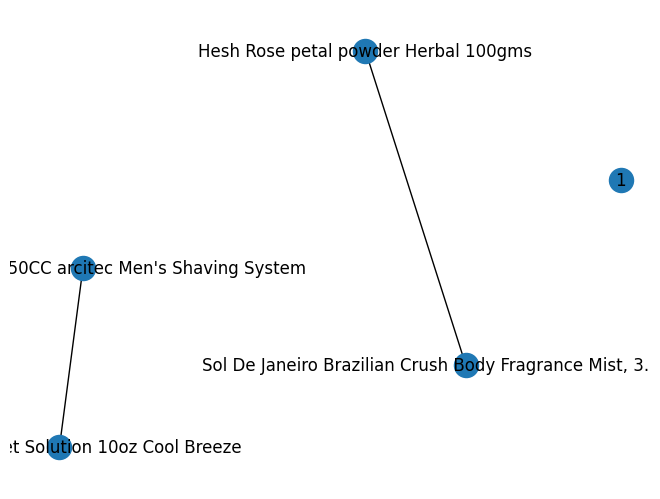

In [62]:
# This function gets the coordinates for nodes
pos = nx.random_layout(G)

# This function gets the weights for the edges 
weight = nx.get_edge_attributes(G,'peso')

# The simplest way to draw a graph is by using nx.draw. 
nx.draw(G,pos, with_labels=True)

# This adds edge lables
nx.draw_networkx_edge_labels(G,pos,edge_labels = weight)
plt.show()

In [ ]:
del  x

In [ ]:
del z